In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib notebook

%load_ext autoreload
%autoreload 2

plt.ion()

In [2]:
from Magnets import Halbachring, Stick, B

In [3]:
h1 = Halbachring(1, 1.2, 1, m = 2, phi = 0)
h2 = Halbachring(0.8, 1, 1, m = 2, phi = -np.pi)

In [4]:
x = np.linspace(-1,1,15)
y = np.linspace(-1,1,15)

X,Y = np.meshgrid(x,y)
Z = X+1j*Y

In [5]:
def change_angles(phi1, phi2):
    global h1, h2
    h1.phi = phi1
    h2.phi = phi2
    plot_config()
    
import ipywidgets as widgets

<IPython.core.display.Javascript object>


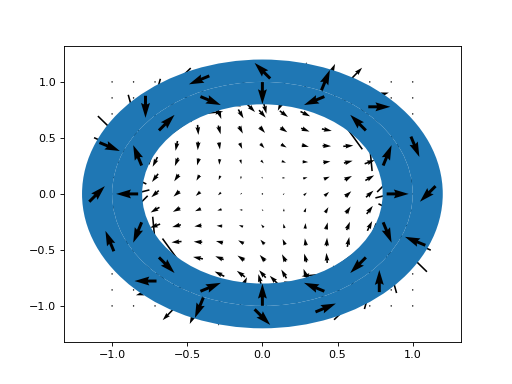

In [6]:
def plot_config():
    plt.gca().cla()
    
    global h1, h2
    Bnum = h1.B(Z) + h2.B(Z)
    plt.quiver(Z.real, Z.imag, Bnum.real, Bnum.imag, pivot = 'mid', scale = 10)
    h1.plot(c = 2)
    h2.plot(c = 1)
    plt.gcf().canvas.draw()
    
plt.figure()
widgets.interact(change_angles, phi1 = (0, np.pi*2, np.pi/8),phi2 = (0,np.pi*2, np.pi/8) );

<IPython.core.display.Javascript object>


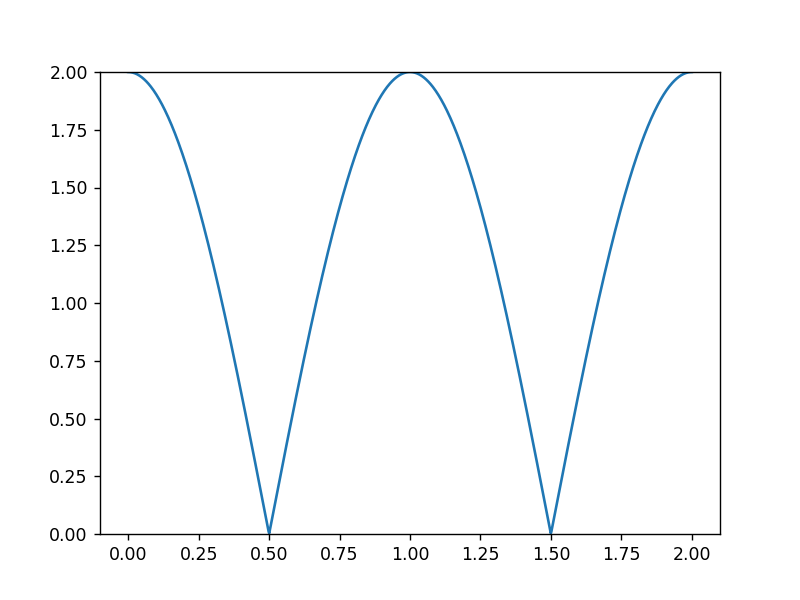

(0, 2)

In [29]:
plt.figure()
phi = np.linspace(0, 2*np.pi, 1000)
plt.plot(phi/np.pi, np.sqrt(2*(1 + np.cos(2*phi))))
plt.ylim(0,2)

<IPython.core.display.Javascript object>


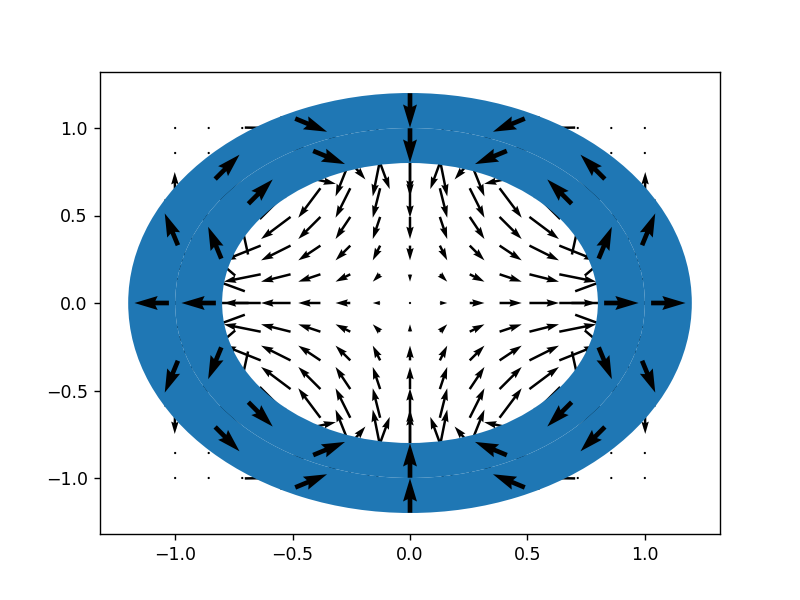

In [9]:
def rotate_contra(phi):
    A = lambda phi: np.sqrt(2*(1+np.cos(2*phi)))
    theta = np.angle(h1.A + np.exp(2j*phi)* h2.A)/2
    change_angles(- theta, phi - theta)
plt.figure()
widgets.interact(rotate_contra, phi = (0, np.pi*2, np.pi/8));

### Perfect Halbach array made of diametricly magnetized infinite Zylinders 

In [37]:
p1 = Stick(0.5,np.exp(1j*np.pi/2), 0)

In [38]:
phalbach_ideal = [Stick(0.18,np.exp(3j*phi),np.exp(1j*phi)) for phi in np.linspace(0,np.pi*2,17)[:-1]]

<IPython.core.display.Javascript object>


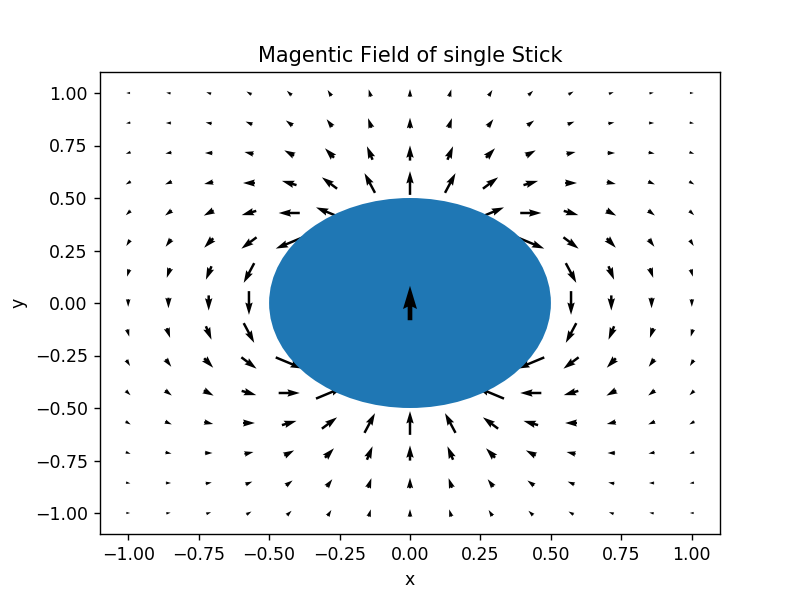

/home/data/Nick/halbachring/Magnets.py:25: RuntimeWarning: divide by zero encountered in true_divide
  return np.where(np.abs(r - self.z0) > self.R, np.conjugate(self.B_r/2*self.R**2/(r-self.z0)**2),0)


In [39]:
fig = plt.figure()
fig.clf()
Bnum = p1.B(Z)
plt.title('Magentic Field of single Stick')
plt.quiver(Z.real, Z.imag, Bnum.real, Bnum.imag, pivot = 'mid', scale = 10)
p1.plot()
plt.xlabel("x")
plt.ylabel("y");

In [40]:
def PlotModel(phalbach, x =  np.linspace(-1,1,15), y = np.linspace(-1,1,15)):

    X,Y = np.meshgrid(x,y)
    Z = X+1j*Y
    fig = plt.figure('Model')
    fig.clf()
    Bnum = B(phalbach, Z)
    plt.quiver(Z.real, Z.imag, Bnum.real, Bnum.imag, pivot = 'mid', scale = 10)
    [p.plot() for p in phalbach]
    plt.xlabel("x")
    plt.ylabel("y")

<IPython.core.display.Javascript object>


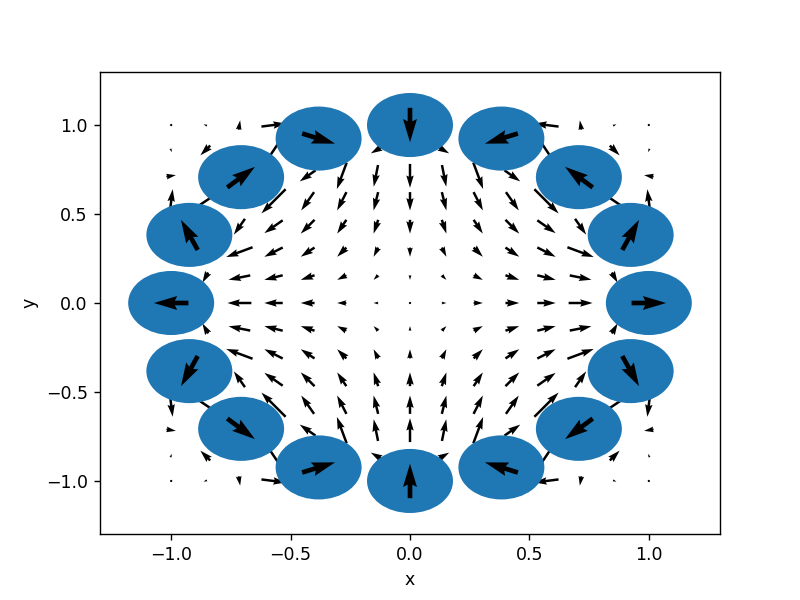

/home/data/Nick/halbachring/Magnets.py:25: RuntimeWarning: divide by zero encountered in true_divide
  return np.where(np.abs(r - self.z0) > self.R, np.conjugate(self.B_r/2*self.R**2/(r-self.z0)**2),0)
/home/data/Nick/halbachring/Magnets.py:25: RuntimeWarning: invalid value encountered in true_divide
  return np.where(np.abs(r - self.z0) > self.R, np.conjugate(self.B_r/2*self.R**2/(r-self.z0)**2),0)


In [41]:
PlotModel(phalbach_ideal)

## Error Study

### Definition of permantent Magnets (Model)

In [71]:
phi0_raw = np.linspace(0,np.pi*2,17)[:-1] 
phi0 = phi0_raw + np.random.normal(0, 1e-3,16)
Mabs = np.random.normal(1,0.1,16)
pos = np.exp(1j*phi0_raw) + np.random.normal(0, 1e-3,16)[0] + 1j *np.random.normal(0, 1e-3,16)
def rotateModel(phi):
    return [Stick(0.18,Mabs[i] * np.exp(3j*phi[i]),pos[i]) for i in range(16)]
phalbach_real = rotateModel(phi0)

### Grid where to solve B field

In [43]:
x = np.linspace(-1,1,100)
y = np.linspace(-1,1,100)

X,Y = np.meshgrid(x,y)
Z = X+1j*Y

Bnum_real = B(phalbach_real, Z)

### Algebraic methods and variables

In [44]:
import sympy as sym

In [45]:
xs = sym.Symbol('x', real = True)
ys = sym.Symbol('y', real = True)
rs = xs + 1j * ys

In [46]:
symB_real = B(phalbach_real, rs, sym = True)

In [47]:
from scipy.misc import factorial
def TaylorCoef(f, n = 1, z0 = 0):
    fa = [f]
    coef = [[sym.lambdify([xs,ys], f)(z0.real, z0.imag)]]
    for i in range(n):
        fa = [sym.diff(fa[0], xs)] + [sym.diff(f,ys) for f in fa]
        coef += [[sym.lambdify([xs,ys], f)(z0.real, z0.imag) for f in fa]]
    return coef

def Taylor(f, n = 1, z0 = 0):
    ct = TaylorCoef(f, n = n, z0 = z0)
    return sum([sum([ct[i][j]/factorial(j)/factorial(i - j)*xs**j * ys**(i-j)  for j in range(len(ct[i]))]) for i in range(len(ct))])

def getnthOrder(f, n,z0 = 0):
    ct = TaylorCoef(f, n = n, z0 = z0)
    return sum([ct[-1][j]/factorial(j)/factorial(n - j)*xs**(n - j) * ys**j  for j in range(len(ct[-1]))])

In [48]:
quadBsym_real = getnthOrder(symB_real, 1)
quadB_real = sym.lambdify([xs,ys],quadBsym_real, 'numpy')(X,Y)
quadBsym_real

x*(0.486765074238136 - 0.000929935764853085*I) + y*(-0.000929935764853085 - 0.486765074238136*I)

<IPython.core.display.Javascript object>


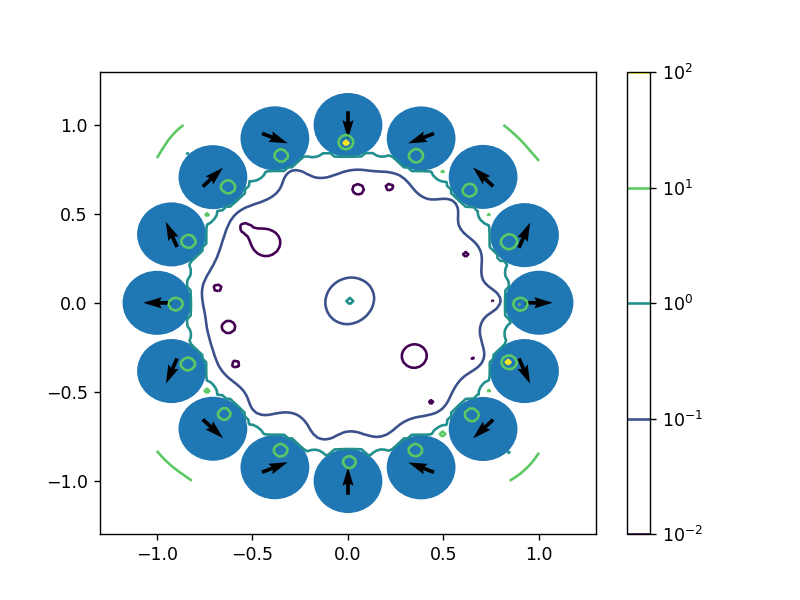

In [49]:
%matplotlib notebook
from matplotlib.colors import LogNorm
Bnum = B(phalbach_real, Z)
deltaB_real = Bnum_real - quadB_real

fig = plt.figure()
fig.clf()
cf = plt.contour(Z.real, Z.imag, np.abs(deltaB_real)/np.abs(Bnum_real), norm = LogNorm())
[p.plot() for p in phalbach_real]
plt.colorbar(cf)
plt.show()

In [50]:
def Error2NPole(Elements, r_max, N = 1):
    
    
    phi = np.linspace(0, 2*np.pi, 1000)[:-1]
    r = np.linspace(0, r_max, 1000)[1:]
    
    PHI, R = np.meshgrid(phi, r)
    
    Z = R * np.exp(1j*PHI)
    
    Bnum = B(Elements,Z)
    Bsym = B(Elements,rs, sym = True)
    
    Bideal = sym.lambdify([xs, ys], getnthOrder(Bsym, n = N))(Z.real, Z.imag) 
    
    Error = np.abs((Bnum - Bideal))
    
    return (2*np.pi)/len(phi)*(r_max/len(r))*np.sum(Error*R) / (np.pi* r_max**2)  

In [51]:
getnthOrder(symB_real, n = 1)

x*(0.486765074238136 - 0.000929935764853085*I) + y*(-0.000929935764853085 - 0.486765074238136*I)

In [52]:
print (Error2NPole(phalbach_real, 0.5))
print (Error2NPole(phalbach_ideal, 0.5))

0.00662847875665
3.7826544537e-06


### Optimization of Angles

In [53]:
phalbach_real2 = rotateModel(phi0)
Error2NPole(phalbach_real2, 0.5)

0.0066284787566467116

In [54]:
def to_min(phi):
    phalbach = rotateModel(phi)
    err =  Error2NPole(phalbach, 0.5)
    return err

In [ ]:
from scipy.optimize import minimize
import time
%matplotlib inline
import warnings

class TookTooLong(Warning):
    pass

class MinimizeStopper(object):
    def __init__(self, preview = False):
        self.preview = preview
    def __call__(self, xk=None):
        if self.preview:
            plt.figure('preview')
            phalbach = rotateModel(xk)
            [p.plot() for p in phalbach]


res = minimize(to_min, phi0, method='Nelder-Mead', callback=MinimizeStopper(preview = False),options={'maxiter': 1000})

In [ ]:
phi_after = res['x']

In [111]:
def ErrorPlot(model, x = np.linspace(-1,1,100), y = np.linspace(-1,1,100)):

    X,Y = np.meshgrid(x,y)
    Z = X+1j*Y

    Bnum_real = B(model, Z)

    symB_real = B(model, rs, sym = True)

    quadBsym_real = getnthOrder(symB_real, 1)
    quadB_real = sym.lambdify([xs,ys],quadBsym_real, 'numpy')(X,Y)

    from matplotlib.colors import LogNorm
    Bnum = B(model, Z)
    deltaB_real = Bnum_real - quadB_real

    fig = plt.figure()
    
    cf = plt.contour(Z.real, Z.imag, np.abs(deltaB_real), norm = LogNorm())
    plt.contour(Z.real, Z.imag, np.abs(deltaB_real), levels = [5e-3], colors = ['black'],norm = LogNorm())
    [p.plot() for p in model]
    plt.colorbar(cf)
    plt.show()

In [80]:
phalbach_real_after = rotateModel(phi_after)
ErrorPlot(phalbach_real_after)
PlotModel(phalbach_real_after)
Error2NPole(phalbach_real_after, 0.5)

NameError: name 'phi_after' is not defined

In [81]:
phalbach_real_0 = rotateModel(phi0)
ErrorPlot(phalbach_real_0)
PlotModel(phalbach_real_0)
Error2NPole(phalbach_real_0, 0.5)

TypeError: 'int' object is not subscriptable

## Realistic Model without Errors

In [113]:
phi0_raw = np.linspace(0,np.pi*2,17)[:-1] 
phi0 = phi0_raw
Mabs = 1.1
pos = np.exp(1j*phi0_raw)
def StrechModel(r,rs):
    return [Stick(rs,Mabs * np.exp(3j*phi0[i]),r*pos[i]) for i in range(16)]

In [114]:
r = 0.04
sm = StrechModel(r,0.005)

In [115]:
symB_sm = B(sm, rs, sym = True)

In [116]:
x = np.linspace(-r,r,15)
y = np.linspace(-r,r,15)


Bnum_real = B(phalbach_real, Z)

<IPython.core.display.Javascript object>


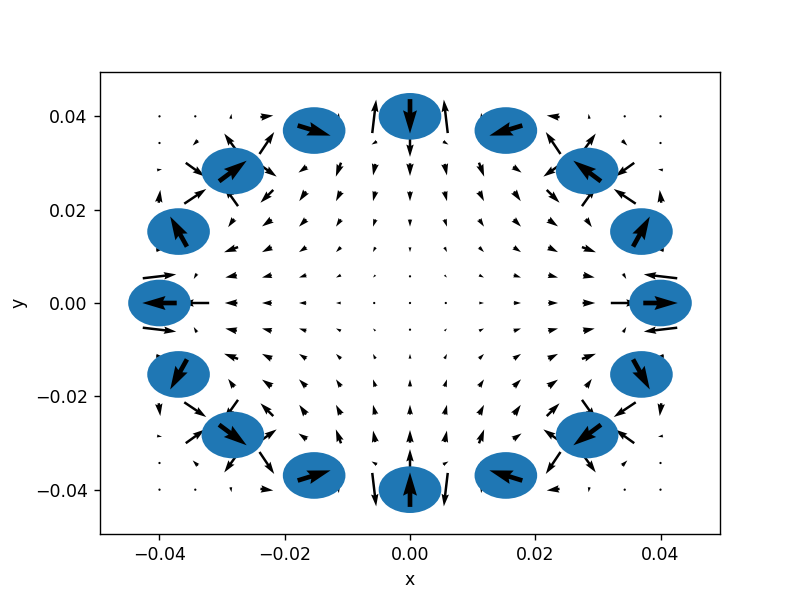

/home/data/Nick/halbachring/Magnets.py:25: RuntimeWarning: divide by zero encountered in true_divide
  return np.where(np.abs(r - self.z0) > self.R, np.conjugate(self.B_r/2*self.R**2/(r-self.z0)**2),0)
/home/data/Nick/halbachring/Magnets.py:25: RuntimeWarning: invalid value encountered in true_divide
  return np.where(np.abs(r - self.z0) > self.R, np.conjugate(self.B_r/2*self.R**2/(r-self.z0)**2),0)


In [117]:
PlotModel(sm, x = x, y = y)

In [118]:
getnthOrder(symB_sm , n = 1)

x*(6.87499999999999 + 3.04142514170276e-15*I) + y*(3.04142514170276e-15 - 6.87499999999999*I)

<IPython.core.display.Javascript object>


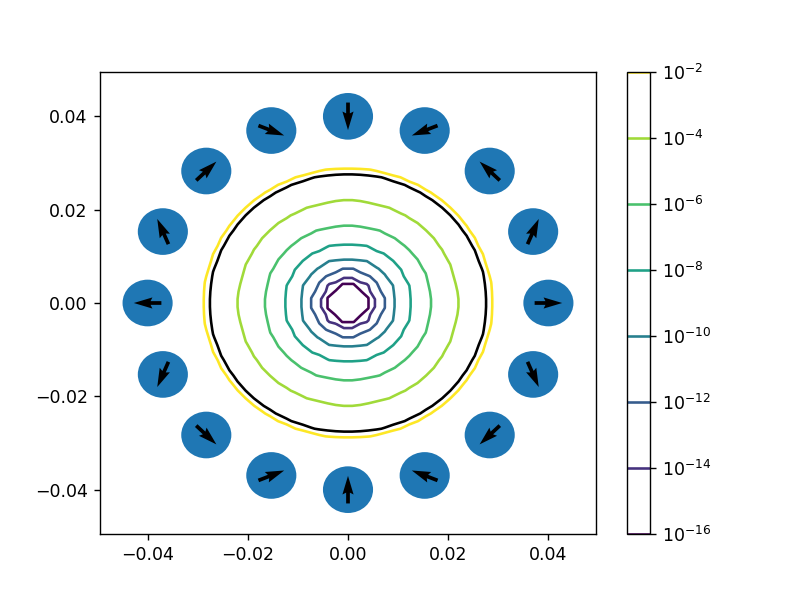

In [119]:
xf = np.linspace(-r,r)
yf = np.linspace(-r,r)

ErrorPlot(sm, x = xf, y = yf)